## **SEMILLAS**

Seeds Inc. es un productor de semillas que cuenta con 2 plantas donde produce semillas de 2 variedades de maíz (amarillo y morado). Las semillas son distribuidas a sus clientes en 2 ciudades diferentes. 

La empresa ha recolectado información sobre el costo de producir una bolsa de semillas de cada variedad en cada una de las plantas, 

el costo de envío de bolsas de cada variedad de maíz desde cada planta a cada ciudad, 

la cantidad de Kg de maíz de cada variedad que se necesita para producir una bolsa de cada variedad de semillas (esta cantidad es independiente de la planta), 

la capacidad de procesamiento (Kg.) de cada planta, y la demanda estimada de cada variedad de maíz en cada ciudad.

¿Cuál es la mejor forma de llevar a cabo la producción y operación?

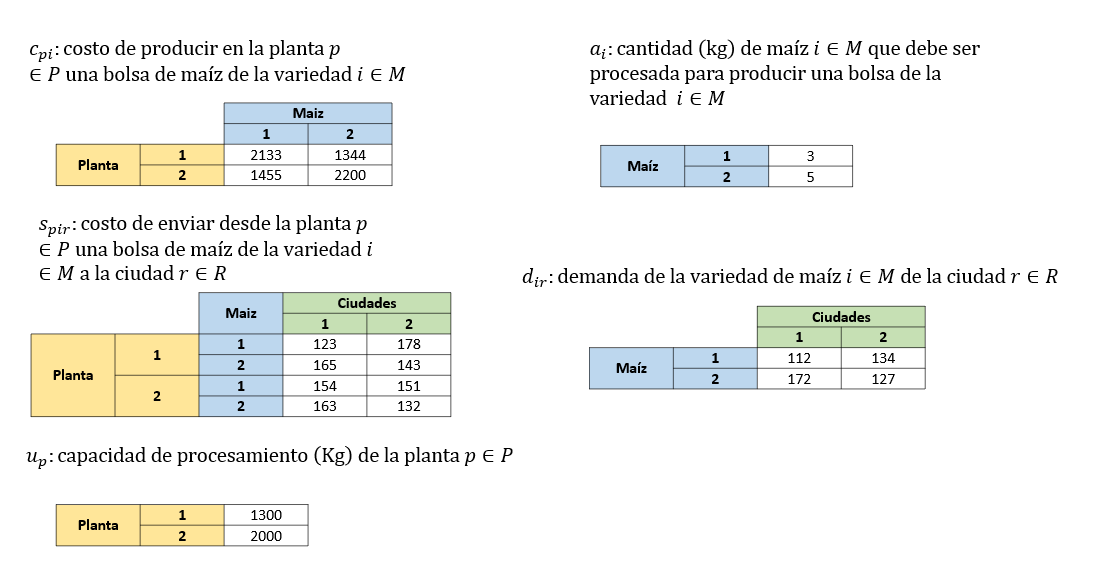


In [21]:
import gurobipy as gp
from gurobipy import GRB

In [22]:
## Conjuntos
P = [1, 2]
M = [1, 2]
R = [1, 2]

In [23]:
## Parámetros
c = {
    1: {1: 2133, 2: 1344}, 
    2: {1: 1455, 2: 2200},
}
d = {1: {1: 112, 2: 134}, 2: {1: 172, 2: 127}}
u = {1: 1300, 2: 2000}
a = {1: 3, 2: 5}

s = {
    (1, 1, 1): 123,
    (1, 1, 2): 178,
    (1, 2, 1): 165,
    (1, 2, 2): 143,
    (2, 1, 1): 154,
    (2, 1, 2): 151,
    (2, 2, 1): 163,
    (2, 2, 2): 132,
}


In [24]:
model = gp.Model(name="Model Semmillas")

$$ x_{pm} \in \mathbb{R}^{+}:  \text{cantidad de bolsas a producir en la planta } p \in P \text{ de la variedad de maíz } m \in M $$
$$ y_{pmr} \in \mathbb{R}^{+}:  \text{cantidad de bolsas a enviar desde la planta } p \in P \text{ de la variedad de maíz } m \in M \text{ a la ciudad } r \in R $$

In [25]:
x = model.addVars(
    [(p, m) for p in P for m in M],
    vtype=GRB.CONTINUOUS,
    name="x",
)
y = model.addVars(
	[(p, m, r) for p in P for m in M for r in R],
    vtype=GRB.CONTINUOUS,
	name="y",
)

$$ \text{minimizar FO: } \sum_{p \in P} \sum_{m \in M} c_{pm} x_{pm} + \sum_{p \in P} \sum_{m \in M} \sum_{r \in R} s_{pmr} y_{pmr} $$

In [26]:
model.setObjective(
    gp.quicksum(c[p][m] * x[p, m] for p in P for m in M) + 
    gp.quicksum(s[p, m, r] * y[p, m, r] for p in P for m in M for r in R),
	GRB.MINIMIZE
)

# costo1 = gp.quicksum(c[p][m] * x[p, m] for p in P for m in M)
# costo2 = gp.quicksum(s[p, m, r] * y[p, m, r] for p in P for m in M for r in R)
# model.setObjective(
#     costo1 + costo2,
# 	GRB.MINIMIZE
# )

$$ \forall p \in P: \sum_{m \in M} a_m x_{pm} \leq u_p $$

In [27]:
## OPC 1
for p in P:
    model.addConstr(gp.quicksum(a[m] * x[p, m] for m in M) <= u[p])

## OPC 2
# model.addConstrs(gp.quicksum(a[m] * x[p, m] for m in M) <= u[p] for p in P)

$$ \forall m \in M \, \forall r \in R: \sum_{p \in P} y_{pmr} \geq d_{mr} $$

In [28]:
for m in M:
    for r in R:
        model.addConstr(gp.quicksum(y[p, m, r] for p in P) >= d[m][r])


$$ \forall m \in M \, \forall p \in P: \sum_{r \in R} y_{pmr} = x_{pm} $$

In [29]:
for m in M:
    for p in P:
        model.addConstr(gp.quicksum(y[p, m, r] for r in R) == x[p, m])

In [30]:
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10 rows, 12 columns and 24 nonzeros
Model fingerprint: 0x46a17616
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+03]
Presolve removed 4 rows and 4 columns
Presolve time: 0.01s
Presolved: 6 rows, 8 columns, 16 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.110000e+02   0.000000e+00      0s
       5    8.7676400e+05   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.02 seconds (0.00 work units)
Optimal objective  8.767640000e+05


In [31]:
model.ObjVal

876764.0

In [32]:
for p in P:
    print(f"Planta {p}")
    for m in M:
        print(f"    Semilla {m}: {x[p, m].X}")
        

Planta 1
    Semilla 1: 0.0
    Semilla 2: 260.0
Planta 2
    Semilla 1: 246.0
    Semilla 2: 39.0


In [33]:
for p in P:
    print(f"Planta {p}")
    for m in M:
        print(f"    Semilla {m}")
        for r in R:
            print(f"      Ciudad {r}: {y[p, m, r].X}")

Planta 1
    Semilla 1
      Ciudad 1: 0.0
      Ciudad 2: 0.0
    Semilla 2
      Ciudad 1: 172.0
      Ciudad 2: 88.0
Planta 2
    Semilla 1
      Ciudad 1: 112.0
      Ciudad 2: 134.0
    Semilla 2
      Ciudad 1: 0.0
      Ciudad 2: 39.0
